SETUP PYSPARK IN GOOGLE COLLAB

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark


SETUP ENVIRONMENTAL VARIABALE AND INITIALIZE SPARK

In [ ]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

findspark.init()


START A SPARK SESSION

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ResultManagement").getOrCreate()


GENERATE STUDENT DATA ( SYNTHETIC DATA ANALYSIS )

In [ ]:
import pandas as pd
import random

students = []
subjects = ["Electronics", "Programming", "Database", "Data Science", "Mathematics", "DSA"]

for i in range(1, 10001):
    student = {
        "ID": f"S{i:05d}",
        "Name": f"Student_{i}",
        "Age": random.randint(18, 25),
        "Department": random.choice(["CSE", "ECE", "IT", "EEE"]),
    }
    for subject in subjects:
        student[subject] = random.randint(30, 100)
    students.append(student)

df = pd.DataFrame(students)
df.to_csv("students_data.csv", index=False)

print("Data generated successfully!")


Data generated successfully!


UPLOAD THE DATA TO GOOGLE DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


MOVING DATASET TO GOOGLE DRIVE

In [ ]:
!mv students_data.csv /content/drive/MyDrive/students_data.csv


LOAD DATA INTO THE PYSPARK

In [ ]:
df = spark.read.csv("/content/drive/MyDrive/students_data.csv", header=True, inferSchema=True)
df.show(5)


+------+---------+---+----------+-----------+-----------+--------+------------+-----------+---+
|    ID|     Name|Age|Department|Electronics|Programming|Database|Data Science|Mathematics|DSA|
+------+---------+---+----------+-----------+-----------+--------+------------+-----------+---+
|S00001|Student_1| 19|       CSE|         47|         61|      60|          87|         90| 41|
|S00002|Student_2| 20|        IT|         85|         98|      95|          37|         87| 64|
|S00003|Student_3| 23|       CSE|         80|         63|      73|          99|         78| 61|
|S00004|Student_4| 25|       CSE|         46|         76|      47|          97|         68| 70|
|S00005|Student_5| 24|       EEE|         81|         99|      39|          46|         67| 49|
+------+---------+---+----------+-----------+-----------+--------+------------+-----------+---+
only showing top 5 rows



DATA CLEANING AND PROCESSING

In [ ]:
#converts marks into gardes
from pyspark.sql.functions import col, when

df = df.withColumn("Total Marks", sum([col(subj) for subj in subjects]))
df = df.withColumn("Average Marks", col("Total Marks") / len(subjects))
df = df.withColumn("Grade", when(col("Average Marks") >= 90, "A+")
                             .when(col("Average Marks") >= 80, "A")
                             .when(col("Average Marks") >= 70, "B")
                             .when(col("Average Marks") >= 60, "C")
                             .when(col("Average Marks") >= 50, "D")
                             .otherwise("F"))

df.show(10)


+------+----------+---+----------+-----------+-----------+--------+------------+-----------+---+-----------+------------------+-----+
|    ID|      Name|Age|Department|Electronics|Programming|Database|Data Science|Mathematics|DSA|Total Marks|     Average Marks|Grade|
+------+----------+---+----------+-----------+-----------+--------+------------+-----------+---+-----------+------------------+-----+
|S00001| Student_1| 19|       CSE|         47|         61|      60|          87|         90| 41|        386| 64.33333333333333|    C|
|S00002| Student_2| 20|        IT|         85|         98|      95|          37|         87| 64|        466| 77.66666666666667|    B|
|S00003| Student_3| 23|       CSE|         80|         63|      73|          99|         78| 61|        454| 75.66666666666667|    B|
|S00004| Student_4| 25|       CSE|         46|         76|      47|          97|         68| 70|        404| 67.33333333333333|    C|
|S00005| Student_5| 24|       EEE|         81|         99|    

ANALYSE PERFORMANCE STATISTICS

In [ ]:
#finding subject wise average marks
from pyspark.sql.functions import avg

df.groupBy().agg(
    avg("Electronics").alias("Avg_Electronics"),
    avg("Programming").alias("Avg_Programming"),
    avg("Database").alias("Avg_Database"),
    avg("Data Science").alias("Avg_DataScience"),
    avg("Mathematics").alias("Avg_Mathematics"),
    avg("DSA").alias("Avg_DSA")
).show()


+---------------+---------------+------------+---------------+---------------+-------+
|Avg_Electronics|Avg_Programming|Avg_Database|Avg_DataScience|Avg_Mathematics|Avg_DSA|
+---------------+---------------+------------+---------------+---------------+-------+
|        64.7115|        65.1823|     64.8963|        65.0535|        64.8478|  65.17|
+---------------+---------------+------------+---------------+---------------+-------+



In [ ]:
#finding top 10 students
df.orderBy(col("Average Marks").desc()).select("ID", "Name", "Total Marks", "Average Marks", "Grade").show(10)


+------+------------+-----------+-----------------+-----+
|    ID|        Name|Total Marks|    Average Marks|Grade|
+------+------------+-----------+-----------------+-----+
|S07979|Student_7979|        552|             92.0|   A+|
|S08608|Student_8608|        547|91.16666666666667|   A+|
|S04030|Student_4030|        547|91.16666666666667|   A+|
|S06110|Student_6110|        545|90.83333333333333|   A+|
|S03746|Student_3746|        544|90.66666666666667|   A+|
|S04733|Student_4733|        542|90.33333333333333|   A+|
|S01202|Student_1202|        540|             90.0|   A+|
|S02280|Student_2280|        539|89.83333333333333|    A|
|S04558|Student_4558|        538|89.66666666666667|    A|
|S09624|Student_9624|        538|89.66666666666667|    A|
+------+------------+-----------+-----------------+-----+
only showing top 10 rows



In [ ]:
#criteria for pass and fail for students
from pyspark.sql.functions import count

total_students = df.count()
passed_students = df.filter(col("Grade") != "F").count()
failed_students = total_students - passed_students

pass_percentage = (passed_students / total_students) * 100
fail_percentage = (failed_students / total_students) * 100

print(f"Pass Percentage: {pass_percentage:.2f}%")
print(f"Fail Percentage: {fail_percentage:.2f}%")


Pass Percentage: 96.49%
Fail Percentage: 3.51%


TO SAVE PROCESSED DATA

In [ ]:
# Rename the columns with spaces before writing to Parquet
df = df.withColumnRenamed("Total Marks", "Total_Marks")
df = df.withColumnRenamed("Average Marks", "Average_Marks")
# Rename the column "Data Science" to "Data_Science"
df = df.withColumnRenamed("Data Science", "Data_Science")

# Now write the data to Parquet
df.write.mode("overwrite").parquet("/content/drive/MyDrive/processed_results.parquet")

VISUALISE DATA USING MATPLOTLIB AND SEABORN

<ipython-input-14-71e4dba08b5f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Grade", data=df_pandas, palette="coolwarm")


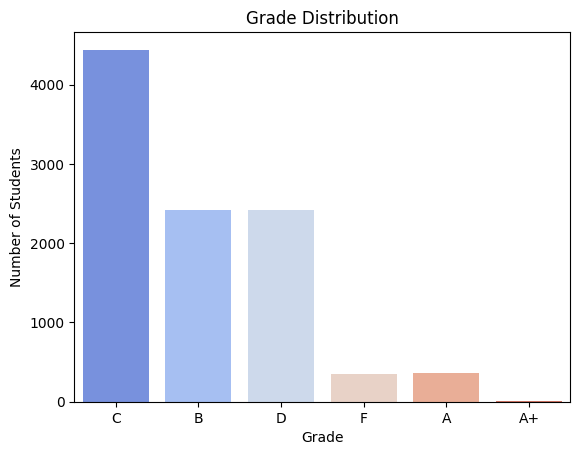

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the processed data back into Pandas
df_pandas = pd.read_parquet("/content/drive/MyDrive/processed_results.parquet")

# Plot Grade Distribution
sns.countplot(x="Grade", data=df_pandas, palette="coolwarm")
plt.title("Grade Distribution")
plt.xlabel("Grade")
plt.ylabel("Number of Students")
plt.show()


In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.7 MB/s eta 0:00:00


DEPLOYMENT OF THE DASHBOARD

In [ ]:
import streamlit as st # Make sure this cell is executed after installing streamlit and restarting the kernel
#If the above import statement works without error then
#You can proceed to use streamlit
st.title("📊 Student Result Dashboard")

st.metric("Total Students", len(df_pandas))
st.bar_chart(df_pandas["Grade"].value_counts())

st.write("Top 10 Students:")
st.dataframe(df_pandas.sort_values(by="Average_Marks", ascending=False).head(10)) # Changed "Average Marks" to "Average_Marks"

2025-03-01 11:57:23.916 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 11:57:24.029 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-01 11:57:24.030 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 11:57:24.033 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 11:57:24.034 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 11:57:24.572 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 11:57:24.576 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 11:57:24.577 Thread 'MainThread': mi

DeltaGenerator()

In [ ]:
!pip install pyngrok flask dash streamlit


INFO: pip is looking at multiple versions of dash to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of dash to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 23.9 MB/s eta 0:00:00


In [ ]:
!ngrok authtoken 2tiC4psokjgtOwqKHSBgq0MHjA2_56UsyJbbUyCQLu49D9jJP

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import streamlit as st
import pandas as pd
import plotly.express as px

st.title("📊 Student Dashboard")

# Sample Data
df = pd.DataFrame({
    "Student": ["Alice", "Bob", "Charlie", "David", "Eve"],
    "Math": [80, 70, 90, 85, 88],
    "Programming": [75, 89, 92, 78, 85]
})

# Bar Chart
st.subheader("📌 Marks in Subjects")
fig = px.bar(df, x="Student", y=["Math", "Programming"], barmode="group")
st.plotly_chart(fig)

# Run Streamlit properly
!nohup streamlit run app.py --server.port 8501 > output.log 2>&1 &


2025-03-01 11:57:40.001 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 11:57:40.002 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 11:57:40.004 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 11:57:40.005 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 11:57:40.641 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 11:57:40.642 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 11:57:40.643 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 11:57:40.644 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd
from flask import Flask
from pyngrok import ngrok

# Sample Data
df = pd.DataFrame({
    "Name": ["Alice", "Bob", "Charlie", "David", "Eve"],
    "Math": [80, 70, 90, 85, 88],
    "Programming": [75, 89, 92, 78, 85]
})

# Initialize Flask and Dash
server = Flask(__name__)
app = dash.Dash(__name__, server=server)

# Dashboard Layout
app.layout = html.Div([
    html.H1("📊 Student Dashboard"),
    dcc.Graph(figure=px.bar(df, x="Name", y=["Math", "Programming"], barmode="group")),
    dcc.Graph(figure=px.line(df, x="Name", y="Math", title="Math Scores Over Students"))
])

# Expose ngrok URL
public_url = ngrok.connect(8050).public_url
print(f"🔗 Public Dashboard Link: {public_url}")

# Run Dash server
app.run_server(port=8050, debug=False, threaded=True)


🔗 Public Dashboard Link: https://2a8b-34-105-69-222.ngrok-free.app
Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8050
INFO:werkzeug:Press CTRL+C to quit


<ipython-input-22-897d3f395a7c>:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



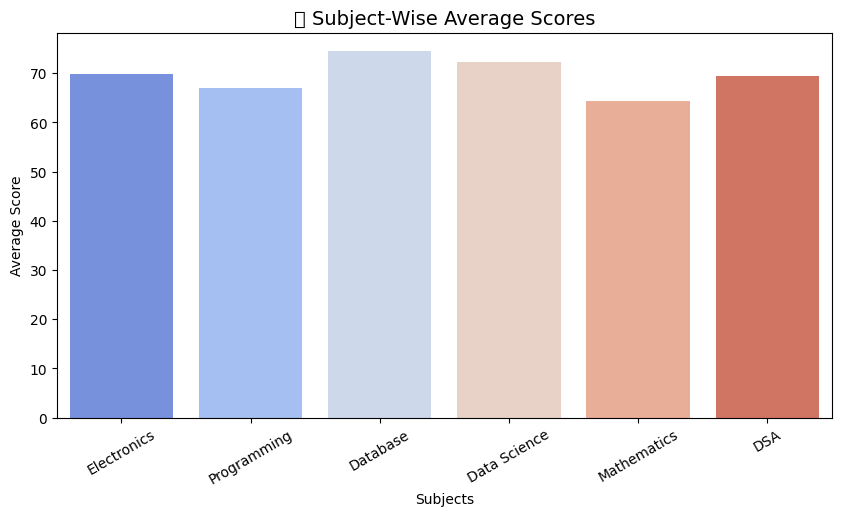

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



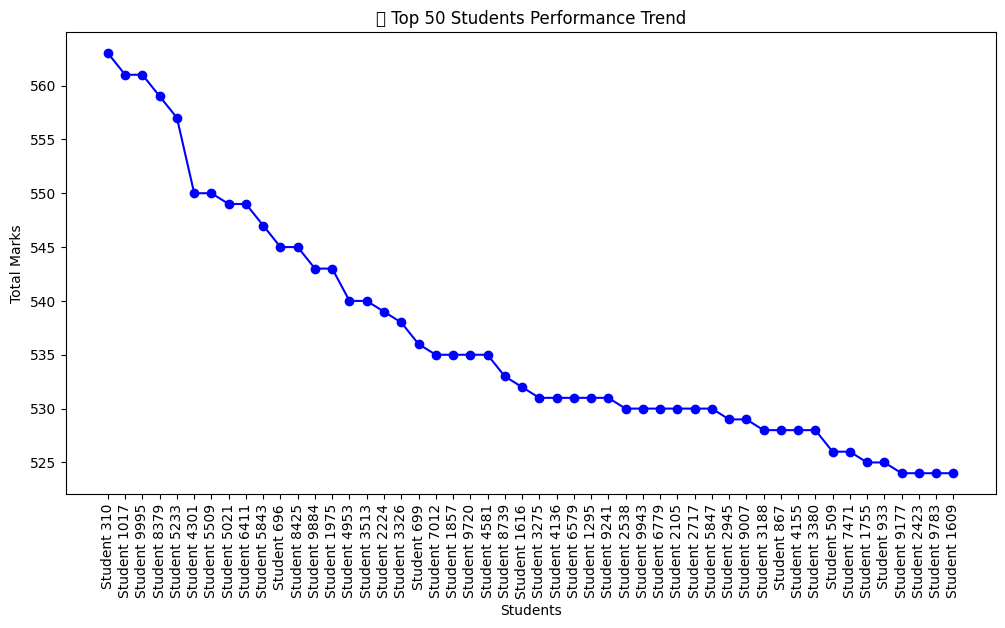

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



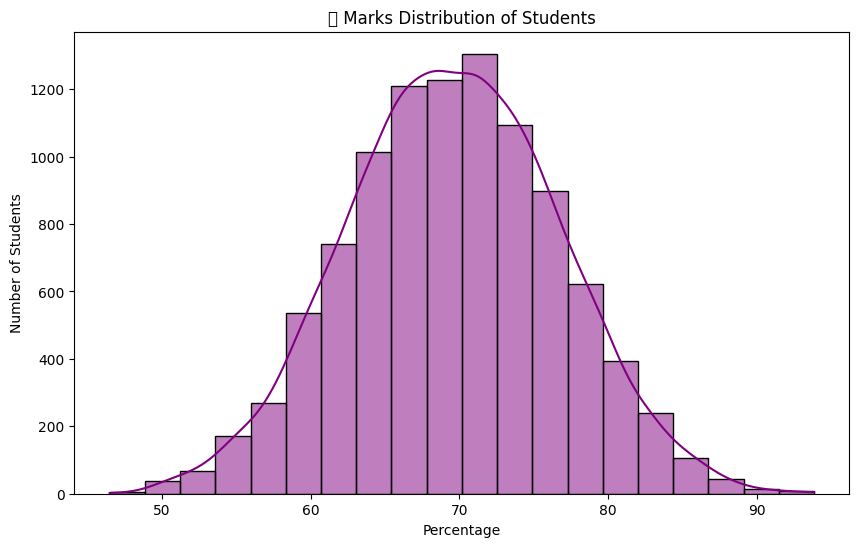

<ipython-input-22-897d3f395a7c>:71: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.



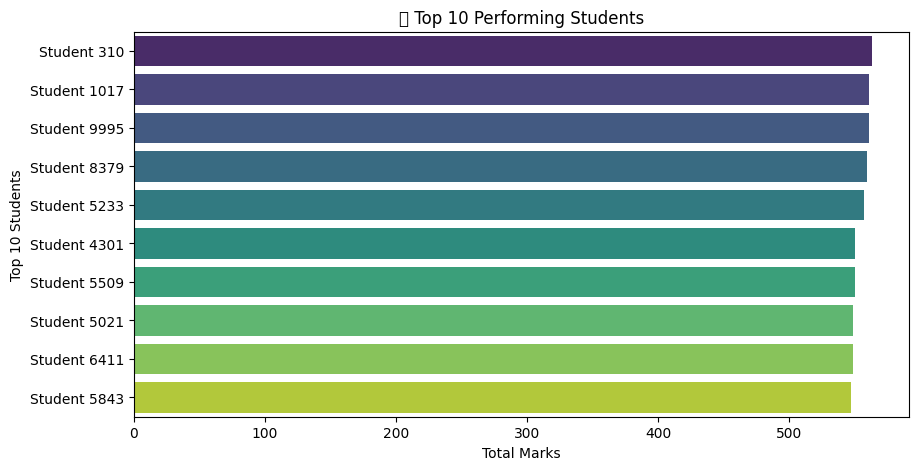

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Generate Sample Data for 10,000 Students
np.random.seed(42)
students = [f"Student {i}" for i in range(1, 10001)]
subjects = ["Electronics", "Programming", "Database", "Data Science", "Mathematics", "DSA"]

# Creating a DataFrame with Random Marks
df = pd.DataFrame({
    "Student": students,
    "Electronics": np.random.randint(40, 100, size=10000),
    "Programming": np.random.randint(35, 100, size=10000),
    "Database": np.random.randint(50, 100, size=10000),
    "Data Science": np.random.randint(45, 100, size=10000),
    "Mathematics": np.random.randint(30, 100, size=10000),
    "DSA": np.random.randint(40, 100, size=10000)
})

# Calculate Total Marks and Pass/Fail Status
df["Total Marks"] = df.iloc[:, 1:].sum(axis=1)
df["Percentage"] = df["Total Marks"] / 6
df["Status"] = df["Percentage"].apply(lambda x: "Pass" if x >= 40 else "Fail")

# ---------- PLOT 1: Subject-Wise Average Scores (Bar Chart) ----------
subject_means = df[subjects].mean()
plt.figure(figsize=(10,5))
sns.barplot(x=subject_means.index, y=subject_means.values, palette="coolwarm")
plt.title("📊 Subject-Wise Average Scores", fontsize=14)
plt.xlabel("Subjects")
plt.ylabel("Average Score")
plt.xticks(rotation=30)
plt.show()

# ---------- PLOT 2: Student Performance Trend (Line Chart) ----------
df_sorted = df.sort_values("Total Marks", ascending=False).head(50)  # Top 50 students
plt.figure(figsize=(12,6))
plt.plot(df_sorted["Student"], df_sorted["Total Marks"], marker="o", linestyle="-", color="b")
plt.xticks(rotation=90)
plt.title("📈 Top 50 Students Performance Trend")
plt.xlabel("Students")
plt.ylabel("Total Marks")
plt.show()

# ---------- PLOT 3: Subject Score Distribution (Pie Chart) ----------
avg_subjects = df[subjects].mean()
fig = px.pie(values=avg_subjects.values, names=avg_subjects.index, title="🥧 Subject Score Distribution")
fig.show()

# ---------- PLOT 4: Pass/Fail Percentage (Pie Chart) ----------
pass_fail_counts = df["Status"].value_counts()
fig = px.pie(values=pass_fail_counts.values, names=pass_fail_counts.index,
             title="📉 Pass vs Fail Percentage", color=pass_fail_counts.index,
             color_discrete_map={"Pass": "green", "Fail": "red"})
fig.show()

# ---------- PLOT 5: Marks Distribution (Histogram) ----------
plt.figure(figsize=(10,6))
sns.histplot(df["Percentage"], bins=20, kde=True, color="purple")
plt.title("📊 Marks Distribution of Students")
plt.xlabel("Percentage")
plt.ylabel("Number of Students")
plt.show()

# ---------- PLOT 6: Top 10 Students (Bar Chart) ----------
df_top10 = df.nlargest(10, "Total Marks")
plt.figure(figsize=(10,5))
sns.barplot(y=df_top10["Student"], x=df_top10["Total Marks"], palette="viridis")
plt.xlabel("Total Marks")
plt.ylabel("Top 10 Students")
plt.title("🏆 Top 10 Performing Students")
plt.show()
